In [1]:
!pip install geopy

  Using cached https://files.pythonhosted.org/packages/a8/5c/ca78a17b2c6fe1179e9221c9280bb5d8caaf048a631ed72caed40c52de24/geopy-1.18.1-py2.py3-none-any.whl
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [53]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.distance import vincenty

In [21]:
## Import Data
# -----------------------------
# 1) Yelp Data Chicago
Yelp_df = pd.read_csv("../Data/Yelp_Restaurants_Chicago.csv")
# 2) Census by Population Chicago
Population_by_Language_df = pd.read_csv("../Data/Population_by_Language_Chicago.csv")

In [23]:
print(Yelp_df.columns)
print(Population_by_Language_df.columns)

Index(['zip', 'city', 'state', 'name', 'price', 'rating', 'review_count',
       'type', 'latitude', 'longitude'],
      dtype='object')
Index(['Population', 'English', 'Spanish', 'French', 'Italian', 'Portuguese',
       'German', 'Greek', 'Russian', 'Polish', 'Chinese', 'Japanese', 'Korean',
       'Thai', 'Vietnamese', 'Arabic', 'Zipcode'],
      dtype='object')


In [30]:
## Get Yelp Data by zip Code and Type Pivotal Table
# --------------------------------
# Count restaurants by Zip Code and Type
Yelp_by_Zipcode_Type_df = Yelp_df.groupby(["zip","type"])["name"].count().reset_index()
Yelp_by_Zipcode_Type_df.rename(columns={"name":"count"},inplace=True)
# Convert to pivotal table
Yelp_by_Zipcode_Type_pt = Yelp_by_Zipcode_Type_df.pivot(index="zip",columns="type",values="count")
# Fill in 0 for NaN
Yelp_by_Zipcode_Type_pt = Yelp_by_Zipcode_Type_pt.fillna(0)
Yelp_Count_by_Zipcode_Type_df = Yelp_by_Zipcode_Type_pt.reset_index()
Yelp_Count_by_Zipcode_Type_df.head()

type,zip,American (New),Arabian,Argentine,Asian Fusion,Austrian,Brazilian,British,Cajun/Creole,Caribbean,...,Latin American,Malaysian,Mediterranean,Mexican,Pakistani,Polish,Portuguese,Russian,Thai,Vietnamese
0,60601,1.0,0.0,0.0,2.0,0.0,0.0,1.0,2.0,1.0,...,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0
1,60602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0
2,60603,5.0,0.0,1.0,4.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,60604,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,60605,1.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,2.0,2.0,1.0,0.0,1.0,0.0,3.0,1.0


In [36]:
common_name_list = list(set(Yelp_Count_by_Zipcode_Type_df.columns).intersection(Population_by_Language_df.columns))
common_name_list

['Thai',
 'Portuguese',
 'Russian',
 'French',
 'Japanese',
 'Chinese',
 'Korean',
 'Vietnamese',
 'Polish',
 'Italian',
 'German',
 'Greek']

In [37]:
# Extract Yelp information needed for analysis
Yelp_Count_by_Zipcode_Type_Clean_df = Yelp_Count_by_Zipcode_Type_df[["zip"]+common_name_list]
Yelp_Count_by_Zipcode_Type_Clean_df.head()

type,zip,Thai,Portuguese,Russian,French,Japanese,Chinese,Korean,Vietnamese,Polish,Italian,German,Greek
0,60601,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,60602,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0
2,60603,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0
3,60604,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60605,3.0,1.0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0


In [63]:
# Extract Census Population information needed for analysis
Population_by_Language_Clean_df = Population_by_Language_df[["Zipcode","Population"]+common_name_list]
Population_by_Language_Clean_df.head()
Percent_by_Language_Clean_df = Population_by_Language_Clean_df[common_name_list].div(Population_by_Language_Clean_df.Population,axis=0)

Percent_by_Language_Clean_df.max()                                                                                               

Thai          0.003928
Portuguese    0.015624
Russian       0.020491
French        0.017753
Japanese      0.044049
Chinese       0.318803
Korean        0.132900
Vietnamese    0.023853
Polish        0.179369
Italian       0.024679
German        0.015171
Greek         0.013716
dtype: float64

In [64]:
## Running Correlation Analysis for each type (Use Absoluate Population Data)
# Update common_name_list
comon_name_clean_list = []
for name in common_name_list:
    if Percent_by_Language_Clean_df[name].max()>=0.02:
        comon_name_clean_list.append(name)

# Population_by_Language_Clean_df["Chinese"].corr(Yelp_Count_by_Zipcode_Type_Clean_df["Chinese"],method="pearson")
corr_matrix = np.zeros((len(comon_name_clean_list),len(comon_name_clean_list)))

for i in range(len(comon_name_clean_list)):
    name_i = comon_name_clean_list[i]
    for j in range(len(comon_name_clean_list)):
        name_j = comon_name_clean_list[j]
        corr_matrix[i,j] = Population_by_Language_Clean_df[name_i].corr(Yelp_Count_by_Zipcode_Type_Clean_df[name_j],method="pearson")
    
Yelp_common_name_list = ["Yelp_"+name for name in comon_name_clean_list]
Census_common_name_list = ["Census_"+name for name in comon_name_clean_list]

corr_df = pd.DataFrame(corr_matrix,index=Census_common_name_list,columns=Yelp_common_name_list)

corr_df


,Yelp_Russian,Yelp_Japanese,Yelp_Chinese,Yelp_Korean,Yelp_Vietnamese,Yelp_Polish,Yelp_Italian
Census_Russian,0.169334,0.301696,0.057577,0.251484,0.033119,0.097274,0.283955
Census_Japanese,-0.015286,0.164729,-0.078414,0.187157,0.077402,-0.021822,0.066120
Census_Chinese,-0.057227,0.052583,0.583820,0.225292,0.060608,-0.030955,0.195657
Census_Korean,0.221703,0.368051,0.170628,0.542699,0.142982,0.069213,0.246491
Census_Vietnamese,0.133490,0.191214,0.160903,0.408693,0.056376,0.071257,0.016622
Census_Polish,-0.032509,0.103457,0.286837,0.137264,0.015396,0.729809,0.202378
Census_Italian,-0.083844,0.285310,0.314524,0.203427,0.001328,0.638411,0.382211


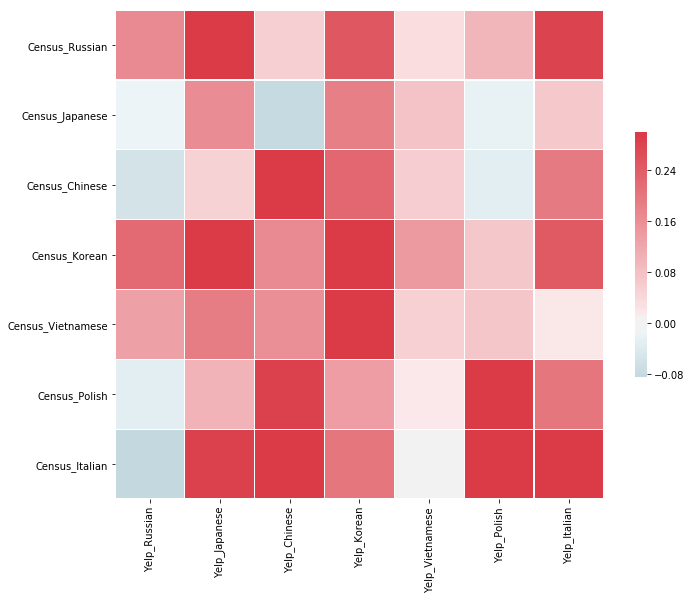

In [65]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df,  cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})